# Violation of Baccari et al.'s Bell inequality for star graphs from size 2 to 39 on IBM Quantum brooklyn

- with measurement error mitigation proposed by Bravyi et al.

## import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display
import pickle
import pprint
import time

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, IBMQ
from qiskit.compiler import transpile
from qiskit.tools.visualization import plot_histogram
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter

### load account

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
backend = provider.get_backend("ibmq_brooklyn")
simulator = Aer.get_backend("qasm_simulator")
device = provider.backends.ibmq_brooklyn

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_13876/4025133605.py:5: DeprecationWarning: The `backends` provider attribute is deprecated. Please use `provider.backend` (singular) instead. You can continue to use `provider.backends()` to retrieve all backends.
  device = provider.backends.ibmq_brooklyn


## create star graph information from size 2 to 39
we test the size from 2 to 39

change the number of 27 of "max_size = len(vertex_list[:27]) # largest graph size" if you want to try up to other size

In [4]:
def adjacency_list_for_star_graph(n):
    """
    Input
        n : int, size of the star graph
    Output
        graph : list of list, adjacency list of the star graph
    """
    graph = []
    if n == 1:
        graph.append([])
    else:
        graph.append(list(range(1,n)))
        for j in range(1, n):
            graph.append([0])
    return graph

def list_to_matrix(graph):
    """
    Input
        graph : list of list (adjacency matrix)
    Output
        adj_matrix : 2d matrix (n * n)
        
    -> time complexity : O(n^2)
    """
    n = len(graph)
    adj_mat = []
    for i in range(n):
        row = [0] * n
        for j in graph[i]:
            row[j] = 1
        adj_mat.append(row)
    return adj_mat

In [5]:
vertex_list =  [19, 
                25, 
                20, 33,
                18, 21, 32,
                34, 17, 12, 31,
                22, 35, 16, 8, 39, 
                11, 30, 23, 36, 15, 7, 45,
                40, 9, 4, 29, 26, 37, 24, 6, 46,
                14, 44, 49, 3, 28, 5, 47] # qubit layout
max_size = len(vertex_list) # largest graph size
Fs = [[0] for n in range(1, max_size + 1)] # subsets of focused vertices of graph size 1 to max_size
adj_lists = [adjacency_list_for_star_graph(n) for n in range(1, max_size + 1)] # adjacency list of graph size 1 to max_size
graphs = [list_to_matrix(adj_list) for adj_list in adj_lists] # adjacency matrix of graph size 1 to max_size
shots_per_circuit = 1 << 13 # shots per one execution

In [6]:
print("max_size:", max_size)
print("shots_per_circuit:", shots_per_circuit)
print("graph_sizes:", [len(adj_list) for adj_list in adj_lists])

max_size: 39
shots_per_circuit: 8192
graph_sizes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


## indicate the order to apply the CNOT gate

In [7]:
# indicate how to connect qubits
order = [[0,1],
         [0,2],[1,3],
         [0,4],[2,5],[3,6],
         [3,7],[4,8],[5,9],[6,10],
         [5,11],[7,12],[8,13],[9,14],[10,15],
         [8,16],[10,17],[11,18],[12,19],[13,20],[14,21],[15,22],
         [12,23],[14,24],[16,25],[17,26],[18,27],[19,28],[20,29],[21,30],[22,31],
         [20,32],[22,33],[23,34],[25,35],[26,36],[30,37],[31,38]]

## prepare quantum circuits graph state without measurements (from size 2 to 39)

In [8]:
def star_graph_state(size, order):
    if size <= 1:
        qc = QuantumCircuit(size)
        return qc
    qc = QuantumCircuit(size)
    qc.h(0)
    for i, j in order:
        qc.cx(i, j)
    qc.x(range(size))
    qc.h(range(1,size))
    return qc

In [9]:
qcs = [star_graph_state(size, order[:size-1]) for size in range(1, max_size+1)]

## add measurements to circuits and QREM circuits -> make a implementation qc list

In [10]:
def prepare_star_graph_qcs(qc,
                           adj_list,
                           optimization_level=0,
                           initial_layout=None):
    """
    Return
        qcs: quantum circuits to be implemented
        nums_divide: numbers of how many the quantum circuits are prepared for one graph
        nums_meas_cal: numbers of measurement calibration circuits
        initial_layouts_: 
    """
    n = qc.num_qubits
    qcs, nums_meas_cal, initial_layouts_ = [], [], []
    
    if n <= 1:
        return [], [], [], []

    # first term: XZZ...Z
    new_qc1 = qc.copy("X" + "Z" * len(adj_list))
    new_qc1 += QuantumCircuit(n, n)
    new_qc1.h(0) # focus on the vertex measured by stabilizer "X"
    new_qc1.barrier()
    new_qc1.measure(range(n), range(n)[::-1]) # measure all
    new_qc1 = transpile(new_qc1, backend=backend, basis_gates=['sx','rz','cx'], 
                        optimization_level=optimization_level, 
                        initial_layout=initial_layout, seed_transpiler=42)

    # second term: ZXX...X
    new_qc2 = qc.copy("Z" + "X" * len(adj_list))
    new_qc2 += QuantumCircuit(new_qc2.num_qubits, n)
    new_qc2.h(range(1,n)) # ZXX...X
    new_qc2.barrier()
    new_qc2.measure(range(n), range(n)[::-1]) # measure all
    new_qc2 = transpile(new_qc2, backend=backend, basis_gates=['sx','rz','cx'], 
                        optimization_level=optimization_level, 
                        initial_layout=initial_layout, seed_transpiler=42)

    # for mitigation circuits
    qr = QuantumRegister(n)
    meas_cal_circuits, _ = tensored_meas_cal(mit_pattern=[[i] for i in range(n)], qr=qr, circlabel='mcal')
    for i, meas_cal_circuit in enumerate(meas_cal_circuits):
        meas_cal_circuits[0] = transpile(meas_cal_circuit, backend=backend, basis_gates=['sx','rz','cx'], 
                                         optimization_level=optimization_level,
                                         initial_layout=initial_layout, seed_transpiler=42)
    nums_meas_cal.append(len(meas_cal_circuits))

    qcs += ([new_qc1, new_qc2] + meas_cal_circuits)
    initial_layouts_ += ( [initial_layout, initial_layout] + [initial_layout] * len(meas_cal_circuits) )

    return qcs, [1,1], nums_meas_cal, initial_layouts_

In [11]:
def prepare_star_graph_qcs_list(qc_graphs,  # list of qiskit.QuantumCircuit
                     adj_lists,             # list of adjacency list
                     optimization_level=0,  # int
                     initial_layouts=None,
                     mitigation_limit=15):
    """
    qcs_list :                   circuits to be executed on the real device
    nums_divide_list :      the information of how I divided a large shots to several circuits
    nums_meas_cal_list : the information of how I prepared the measurement_circuits for CTMP calibration
    initial_layouts_list :     used in execute_circuits function
    """
    qcs_list, nums_divide_list, nums_meas_cal_list, initial_layouts_list = [], [], [], []
    if initial_layouts == None:
        initial_layouts = [list(range(len(adj_list))) for adj_list in adj_lists]
    for i, (qc, adj_list, initial_layout) in enumerate(zip(qc_graphs, adj_lists, initial_layouts)):
        qcs, nums_divide, nums_meas_cal, initial_layouts_ = \
            prepare_star_graph_qcs(qc, 
                                   adj_list,
                                   optimization_level=optimization_level, 
                                   initial_layout=initial_layout)
        nums_meas_cal_list.append(nums_meas_cal)
        initial_layouts_list += initial_layouts_
        qcs_list += qcs
        nums_divide_list.append(nums_divide)
    return qcs_list, nums_divide_list, nums_meas_cal_list, initial_layouts_list

In [12]:
qcs_list, nums_divide_list, nums_meas_cal_list, initial_layouts_list = \
    prepare_star_graph_qcs_list(qcs, 
                                adj_lists, 
                                optimization_level=0,
                                initial_layouts=[vertex_list[:qc.num_qubits] for qc in qcs],
                                mitigation_limit=100)
print("the number of graph state circuits is: ", len(qcs_list))

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_13876/3447937602.py:20: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  new_qc1 += QuantumCircuit(n, n)
/Users/yangbo/opt/anaconda3/envs/qiskitenv/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


the number of graph state circuits is:  152


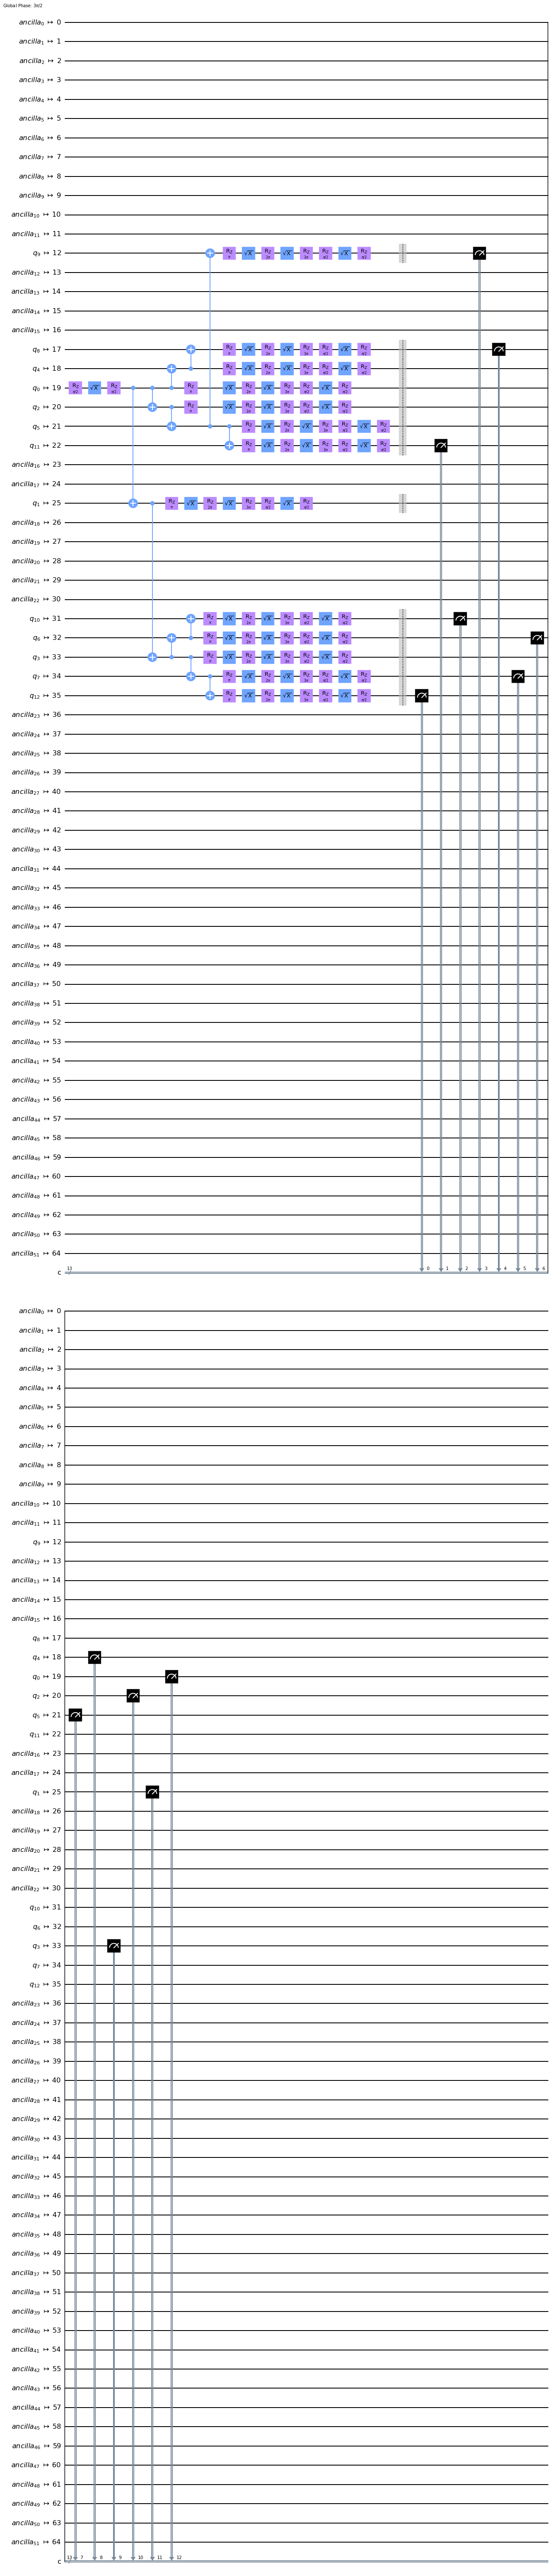

In [13]:
qcs_list[0 + 44].draw("mpl")

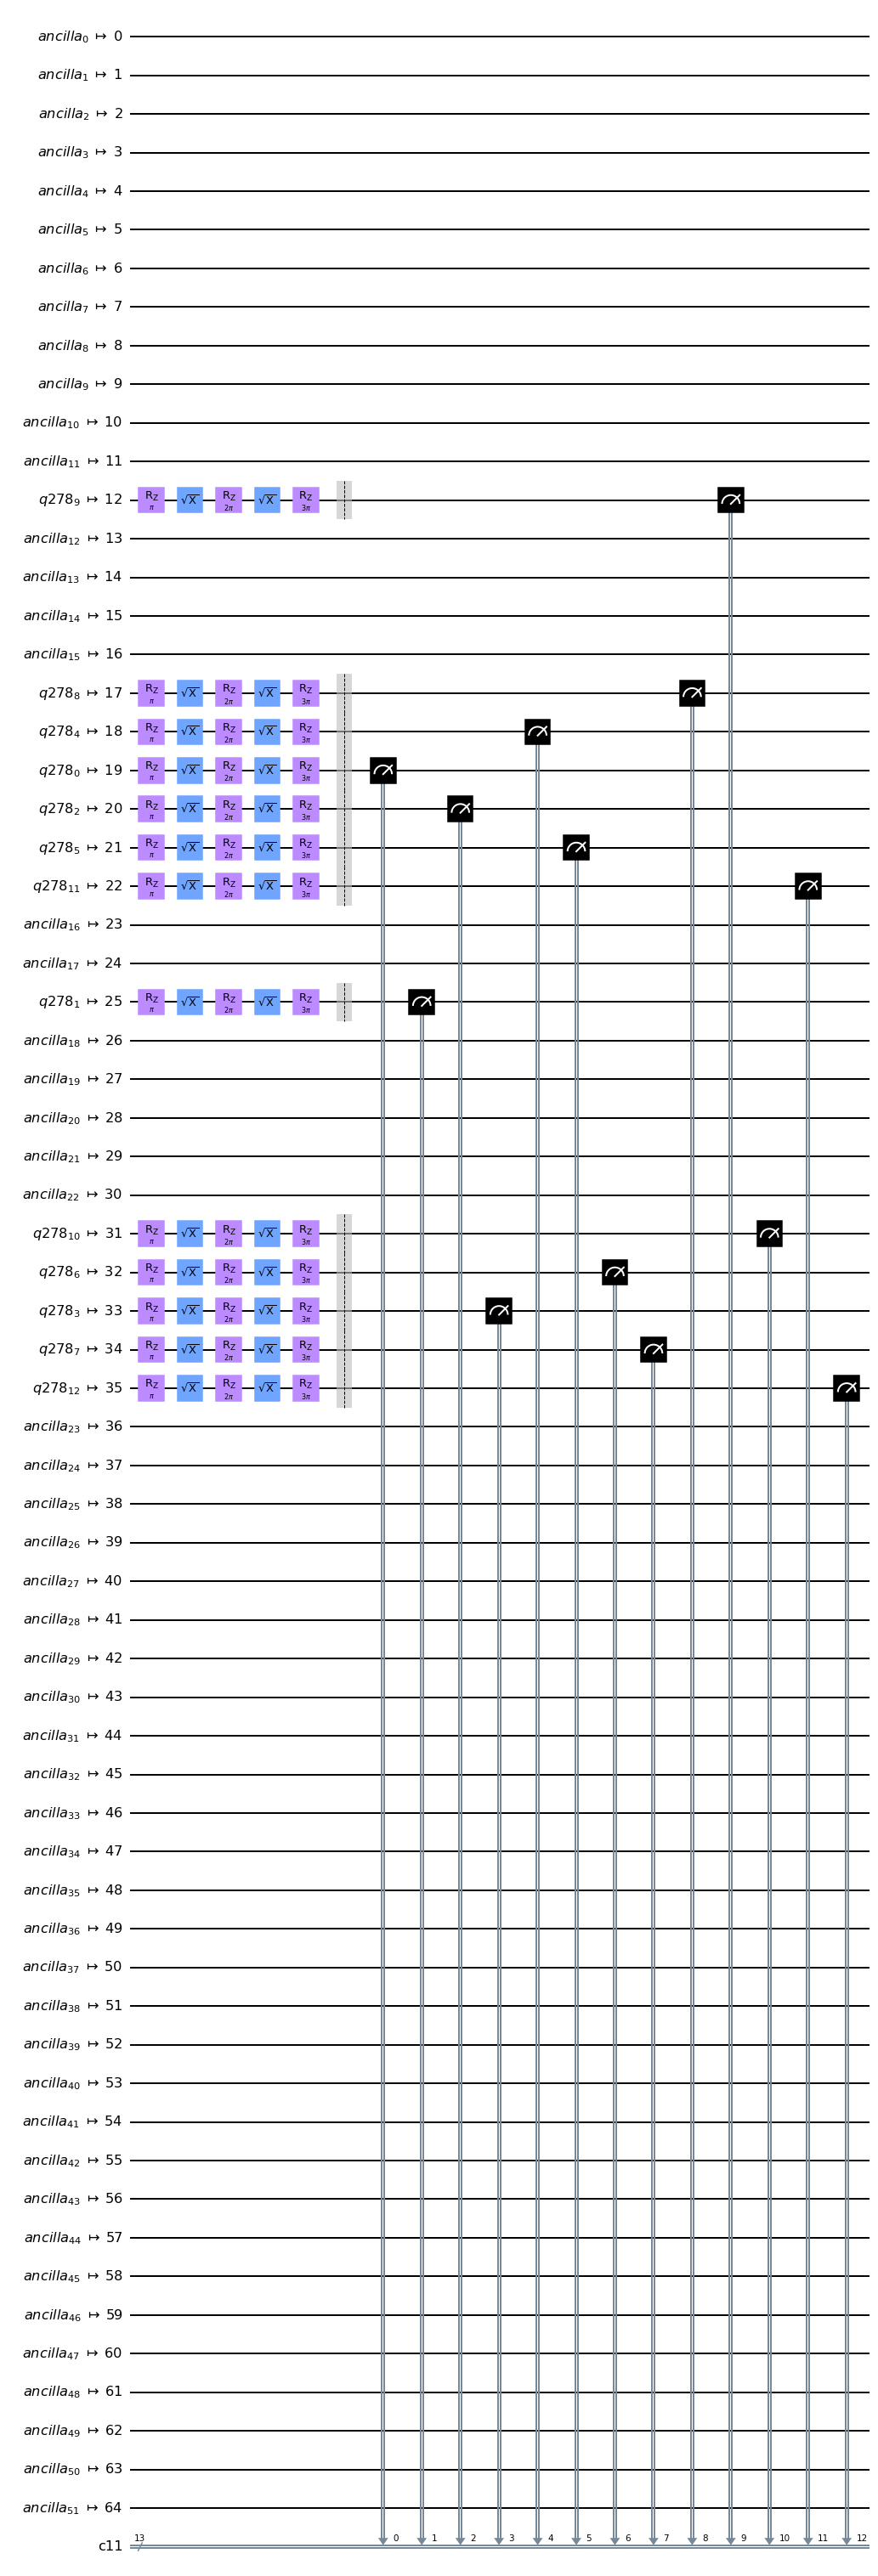

In [14]:
qcs_list[0 + 46].draw("mpl")

In [15]:
print(len(qcs_list), "quantum circuits")
print("length of initial_layouts_list: ", len(initial_layouts_list))

152 quantum circuits
length of initial_layouts_list:  152


In [16]:
qcs_depths = [qc.depth() for qc in qcs[1:]]
print("qcs_depth:", qcs_depths)

qcs_depth: [4, 5, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11]


## cast jobs to ibmq_brooklyn and save job ids

In [17]:
def execute_circuits(qcs, 
                     backend,
                     shots = 8192, 
                     max_experiments = 900,
                     optimization_level = 0):
    print("given provider: ", provider)
    print("running on", backend)
    jobs, i = [], 0
    while i < len(qcs):
        jobs.append(execute(qcs[i:i + max_experiments], backend=backend, shots=shots, optimization_level=optimization_level))
        print("circuits from", i, "to", min(i + max_experiments - 1, len(qcs)), "are put on the real device.")
        i += max_experiments
    return jobs

In [18]:
jobs = execute_circuits(qcs_list,
                        backend=backend,
                        shots=shots_per_circuit,
                        max_experiments=900,
                        optimization_level=1)
print(len(jobs), "jobs")

given provider:  <AccountProvider for IBMQ(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')>
running on ibmq_brooklyn
circuits from 0 to 152 are put on the real device.
1 jobs


In [19]:
job_ids_filename = "job_ids_brooklyn_star.pkl"

## save job_id and machine property to pickle file

In [21]:
with open(job_ids_filename, "wb") as f:
    pickle.dump([job.job_id() for job in jobs], f)

In [22]:
with open("brooklyn_properties_star.pkl", "wb") as f:
    pickle.dump(device.properties(), f)

In [23]:
def arrange_results_list_tensored(results_list, nums_divide_list, nums_meas_cal_list, limit=100):
    pos = 0
    results_graph_states = []
    results_meas_cal = []
    for i, (nums_divide, nums_meas_cal) in enumerate(zip(nums_divide_list, nums_meas_cal_list)): # graph wise
        for num_divide in nums_divide: # term wise
            results_graph_states += results_list[pos:pos + num_divide]
            pos += num_divide
        if i < limit: # start from 2
            for num_meas_cal in nums_meas_cal: # term wise
                results_meas_cal.append(merge_results(results_list[pos:pos + 2]))
                pos += num_meas_cal
    return results_graph_states, results_meas_cal

In [ ]:
with open(job_ids_filename, "rb") as f:
     job_ids = pickle.load(f)
results_jobs_list = job_ids_to_result(job_ids, device)
print("length of results_jobs_list: ", len(results_jobs_list))
results_list = flatten_results_jobs_list(results_jobs_list)
print("length of results_list: ", len(results_list))
del results_jobs_list
results_graph_states, results_meas_cal = arrange_results_list_tensored(results_list, nums_divide_list, nums_meas_cal_list, limit=100)
print("length of results_meas_cal: ", len(results_meas_cal))
del results_list

In [ ]:
counts_dict_list = results_list_to_counts_dict_list(results_graph_states)
print("length of counts_dict_list: ", len(counts_dict_list))
del results_graph_states

In [ ]:
tensored_meas_mitigator_list = []
for n in range(2, max_size + 1):
    qr = qiskit.QuantumRegister(n)
    mit_pattern = [[i] for i in range(n)]
    meas_fitter = TensoredMeasFitter(results_meas_cal[n - 2], mit_pattern=mit_pattern)
    tensored_meas_mitigator_list.append( meas_fitter.filter )
print("length of tensored_meas_mitigator_list: ", len(tensored_meas_mitigator_list))
del results_meas_cal

## compute correlation

In [ ]:
def analyze_circuits_tensored(adj_lists, counts_dict_list, tensored_meas_mitigator_list=None, limit=100):
    """
    Input
        adj_lists         : list of adjacency list
        counts_list       : list of int list (list of counts)
        meas_mitigator : measurement mitigator
    Output
        expval_all_list : list of float (correlation of each graph)
        stddev_all_list : list of float (standard deviation of each graph)
        Es_all_list   : list of list (term-wise correlation of each graph)
        Ds_all_list   : list of list (term-wise stddev of each graph)
    """
    expval_all_list, stddev_all_list, Es_all_list, Ds_all_list = [], [], [], []
    for adj_list in adj_lists:
        t1 = time.time()
        n = len(adj_list)
        if n > limit:
            break
        print("graph size:", n)
        if n <= 1:
            print("skipped\n")
            expval_all_list.append(0)
            stddev_all_list.append(0)
            Es_all_list.append([])
            Ds_all_list.append([])
            continue

        # for the first term
        print("first term")
        counts = tensored_meas_mitigator_list[n - 2].apply( counts_dict_list[2 * (n - 2)] ) # n = 2 -> 0, n = 10 -> 16
        expval1, stddev1 = mit.expectation_value(counts, 
                                                 qubits=range(n),
                                                 clbits=range(n),
                                                 meas_mitigator=None)
        Es_1, Ds_1 = [expval1], [stddev1]


        # for the second term
        print("second term")
        Es_2, Ds_2 = [], []
        sum_expval2, sum_stddev2 = 0, 0
        counts = tensored_meas_mitigator_list[n - 2].apply( counts_dict_list[2 * (n - 2) + 1] ) # n = 2 -> 1, n = 10 -> 17
        for pos in range(1, n): # recover the two qubit expectation values
            expval2, stddev2 = mit.expectation_value(extract_two_qubit_counts(counts, 0, pos), 
                                                     qubits=[0,pos],
                                                     clbits=[0,pos],
                                                     meas_mitigator=None)
            Es_2.append(expval2)
            Ds_2.append(stddev2)
        sum_stddev2 = compute_stddev_of_grouping(Ds_2)

        sum_expval = np.sqrt(2) * ((n - 1) * sum(Es_1) + sum(Es_2))
        sum_stddev = np.sqrt(2 * ((stddev1 * (n - 1)) ** 2 +  sum_stddev2 ** 2) )
        Es = [Es_1, Es_2]
        Ds = [Ds_1, Ds_2]

        expval_all_list.append(sum_expval)
        stddev_all_list.append(sum_stddev)
        Es_all_list.append(Es)
        Ds_all_list.append(Ds)
        t2 = time.time()
        print("time:", t2 - t1)
        print("total correlation:", sum_expval, "\n\n\n")
    return expval_all_list, stddev_all_list, Es_all_list, Ds_all_list

In [ ]:
# with tensored mitigation
tensored_size = 12
tensored_corr_list_real, tensored_stddev_list_real, tensored_Es_list_real, tensored_Ds_list_real = analyze_circuits_tensored(adj_lists, 
                                                                                                                            counts_dict_list,
                                                                                                                            tensored_meas_mitigator_list,
                                                                                                                            limit=tensored_size)

## Plot correlations

In [ ]:
# theoretical bounds
c_bounds = [2 * i for i in range(max_size)]
q_bounds = [2 * np.sqrt(2) * i for i in range(max_size)]

In [ ]:
plt.clf()
plt.plot(list(range(1, max_size + 1)), c_bounds[:max_size], label="Classical bounds", marker="o", markersize=3)
plt.plot(list(range(1, max_size + 1)), q_bounds[:max_size], label="Quantum bounds", marker="x", markersize=3)
plt.errorbar(list(range(1, max_size + 1)), corr_list_real[:max_size], label="Actual correlations", fmt="v", yerr=stddev_list_real[:max_size], capsize=3)
plt.errorbar(list(range(1, tensored_size + 1)), tensored_corr_list_real[:tensored_size], label="Mitigated correlations", fmt="*", yerr=tensored_stddev_list_real[:tensored_size], capsize=3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("graph size")
plt.ylabel("correlation")
plt.xticks(list(range(max_size + 2)))
plt.title("correlation of star graphs (ibmq_brooklyn)")
plt.show()

In [ ]:
plt.clf()
plt.plot(list(range(1, max_size + 1)), c_bounds[:max_size], label="Classical bounds") # , marker="o", markersize=3)
plt.plot(list(range(1, max_size + 1)), q_bounds[:max_size], label="Quantum bounds") # , marker="x", markersize=3)
plt.errorbar(list(range(1, max_size + 1)), corr_list_real[:max_size], label="Actual correlations", fmt="o", yerr=stddev_list_real[:max_size], capsize=3)
plt.errorbar(list(range(1, tensored_size + 1)), tensored_corr_list_real[:tensored_size], label="Mitigated correlations", fmt="*", yerr=tensored_stddev_list_real[:tensored_size], capsize=3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("graph size")
plt.ylabel("correlation")
plt.xticks(list(range(max_size + 2))[::2])
plt.title("correlation of star graphs (ibmq_brooklyn)")
plt.show()

In [ ]:
each_corr_list = [[0]] + [E_1 + Es_2 for E_1, Es_2 in Es_list_real[1:]]
tp_each_corr_list = []
for i in range(len(each_corr_list)):
    tp_each_corr_list.append([each_corr_list[j][i] for j in range(i, len(each_corr_list))])
# pprint.pprint(tp_each_corr_list)

In [ ]:
each_stddev_list = [[0]] + [D_1 + Ds_2 for D_1, Ds_2 in Ds_list_real[1:]]
tp_each_stddev_list = []
for i in range(len(each_stddev_list)):
    tp_each_stddev_list.append([each_stddev_list[j][i] for j in range(i, len(each_stddev_list))])
# pprint.pprint(tp_each_corr_list)

In [ ]:
plt.clf()
for i, (each_corr, each_stddev) in enumerate(zip(tp_each_corr_list, tp_each_stddev_list)):
    if i == 0:
        plt.plot(list(range(2, max_size + 1)), each_corr[1:], color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))])
        plt.errorbar(list(range(2, max_size + 1)), each_corr[1:], label=str(i), color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))], fmt="x", yerr=each_stddev[1:], capsize=3)
    else:
        plt.plot(list(range(i+1, max_size + 1)), each_corr, color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))])
        plt.errorbar(list(range(i+1, max_size + 1)), each_corr, label=str(i), color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))], fmt="v", yerr=each_stddev, capsize=3)
#  plt.plot(list(range(1, max_size + 1)), damped_vibration, label="damped vibration", color=[0, 0, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("graph size")
plt.ylabel("correlation")
plt.xticks(list(range(max_size + 2)))
plt.ylim([-1,1])
plt.title("correlation of each term (ibmq_brooklyn)")
plt.show()

In [ ]:
mitigated_each_corr_list = [[0]] + [E_1 + Es_2 for E_1, Es_2 in tensored_Es_list_real[1:]]
mitigated_tp_each_corr_list = []
for i in range(len(mitigated_each_corr_list)):
    mitigated_tp_each_corr_list.append([mitigated_each_corr_list[j][i] for j in range(i, len(mitigated_each_corr_list))])
# pprint.pprint(tp_each_corr_list)

In [ ]:
mitigated_each_stddev_list = [[0]] + [D_1 + Ds_2 for D_1, Ds_2 in tensored_Ds_list_real[1:]]
mitigated_tp_each_stddev_list = []
for i in range(len(mitigated_each_stddev_list)):
    mitigated_tp_each_stddev_list.append([mitigated_each_stddev_list[j][i] for j in range(i, len(mitigated_each_stddev_list))])
# pprint.pprint(tp_each_corr_list)

In [ ]:
plt.clf()
for i, (each_corr, each_stddev) in enumerate(zip(mitigated_tp_each_corr_list, mitigated_tp_each_stddev_list)):
    if i == 0:
        plt.plot(list(range(2, tensored_size + 1)), each_corr[1:], color=[min(1, 2*i/tensored_size), 0, min(1, 2*(1-i/tensored_size))])
        plt.errorbar(list(range(2, tensored_size + 1)), each_corr[1:], label=str(i), color=[min(1, 2*i/tensored_size), 0, min(1, 2*(1-i/tensored_size))], fmt="x", yerr=each_stddev[1:], capsize=3)
    else:
        plt.plot(list(range(i+1, tensored_size + 1)), each_corr, color=[min(1, 2*i/tensored_size), 0, min(1, 2*(1-i/tensored_size))])
        plt.errorbar(list(range(i+1, tensored_size + 1)), each_corr, label=str(i), color=[min(1, 2*i/tensored_size), 0, min(1, 2*(1-i/tensored_size))], fmt="v", yerr=each_stddev, capsize=3)
#  plt.plot(list(range(1, tensored_size + 1)), damped_vibration, label="damped vibration", color=[0, 0, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("graph size")
plt.ylabel("correlation")
plt.xticks(list(range(tensored_size + 2)))
plt.ylim([-1,1])
plt.title("mitigated correlation of each term (ibmq_brooklyn)")
plt.show()

In [ ]:
plt.clf()
for i, (each_corr, each_stddev) in enumerate(zip(mitigated_tp_each_corr_list, mitigated_tp_each_stddev_list)):
    if i == 0:
        plt.plot(list(range(2, tensored_size + 1)), each_corr[1:], color=[min(1, 2*i/tensored_size), 0, min(1, 2*(1-i/tensored_size))])
        plt.errorbar(list(range(2, tensored_size + 1)), each_corr[1:], label=str(i), color=[min(1, 2*i/tensored_size), 0, min(1, 2*(1-i/tensored_size))], fmt="x", yerr=each_stddev[1:], capsize=3)
    else:
        plt.plot(list(range(i+1, tensored_size + 1)), each_corr, color=[min(1, 2*i/tensored_size), 0, min(1, 2*(1-i/tensored_size))])
        plt.errorbar(list(range(i+1, tensored_size + 1)), each_corr, label=str(i), color=[min(1, 2*i/tensored_size), 0, min(1, 2*(1-i/tensored_size))], fmt="v", yerr=each_stddev, capsize=3)
#  plt.plot(list(range(1, tensored_size + 1)), damped_vibration, label="damped vibration", color=[0, 0, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("graph size")
plt.ylabel("correlation")
plt.xticks(list(range(tensored_size + 2)))
plt.ylim([-1,1.1])
plt.title("mitigated correlation of each term (ibmq_brooklyn)")
plt.show()

In [ ]:
plt.clf()
for i, (each_corr, each_stddev) in enumerate(zip(mitigated_tp_each_corr_list, mitigated_tp_each_stddev_list)):
    if i == 0:
        plt.plot(list(range(2, max_size + 1)), each_corr[1:], color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))])
        plt.errorbar(list(range(2, max_size + 1)), each_corr[1:], label=str(i), color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))], fmt="x", yerr=each_stddev[1:], capsize=3)
    else:
        plt.plot(list(range(i+1, max_size + 1)), each_corr, color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))])
        plt.errorbar(list(range(i+1, max_size + 1)), each_corr, label=str(i), color=[min(1, 2*i/max_size), 0, min(1, 2*(1-i/max_size))], fmt="v", yerr=each_stddev, capsize=3)
#  plt.plot(list(range(1, max_size + 1)), damped_vibration, label="damped vibration", color=[0, 0, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("graph size")
plt.ylabel("correlation")
plt.xticks(list(range(max_size + 2)))
plt.ylim([-1,1.1])
plt.title("mitigated correlation of each term (ibmq_brooklyn)")
plt.show()